In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

## Imports

In [18]:
# modified from test.ipynb and main.py

import time
from utils import plot_3d_boundary, plot_3d_observed_rewards
from pylab import *
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import GPy

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

from emukit.model_wrappers import GPyModelWrapper
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy

from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.loop import UserFunctionWrapper

from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.initial_designs import RandomDesign

from GPy.models import GPRegression

from skopt.benchmarks import branin as _branin
from emukit.test_functions import branin_function

from scse.api.simulation import run_simulation

from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.quadrature.loop import VanillaBayesianQuadratureLoop

# Acquisition functions 
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.experimental_design.acquisitions import ModelVariance
# from emukit.quadrature.acquisitions import IntegralVarianceReduction
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction

# Acquistion optimizers
from emukit.core.optimization import GradientAcquisitionOptimizer

# Stopping conditions
from emukit.core.loop import FixedIterationsStoppingCondition
from emukit.core.loop import ConvergenceStoppingCondition

from emukit.bayesian_optimization.acquisitions.log_acquisition import LogAcquisition

# Constraints
from emukit.core.constraints import LinearInequalityConstraint



In [3]:
# Libraries for multiprocessing
from multiprocess.pool import Pool
from tqdm.auto import tqdm

In [4]:
from loop import *

## miniSCOT Functions

In [5]:
def invoke_miniscot(x):
    """
    Handling single API call to miniSCOT simulation given some inputs

    x contains parameter configs x = [x0 x1 ...]
    - The order of parameters in x should follow the order specified in the parameter_space declaration
    - E.g. here we specify num_batteries = x[0]
    """

    kwargs = {
        'time_horizon': 336*1,
        'num_batteries': int(x[0])
    }

    if len(x) == 2:
        kwargs.update({
            'max_battery_capacity': int(x[1])
        })

    if len(x) == 3:
        kwargs.update({
            'max_battery_capacity': int(x[1]),
            'time_horizon': int(x[2])
        })

    cum_reward = run_simulation(**kwargs)
    
    return cum_reward[-1]

In [6]:
def f(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    Y = []
    for x in X:
        cum_reward = invoke_miniscot(x)

        # Note that we negate the reward; want to find min
        Y.append(-cum_reward[-1])

    Y = np.reshape(np.array(Y), (-1, 1))
    return Y

In [7]:
def f_multiprocess(X):
    """
    Handling multiple API calls to miniSCOT simulation given some inputs using multiprocessing.

    X is a matrix of parameters
    - Each row is a set of parameters
    - The order of parameters in the row should follow the order specified in the parameter_space declaration
    """
    
    # Set to None to use all available CPU
    max_pool = None
    with Pool(max_pool) as p:
        Y = list(
            tqdm(
                p.imap(invoke_miniscot, X),
                total=X.shape[0]
            )
        )

    # Note that we negate the reward; want to find min
    Y = -np.reshape(np.array(Y), (-1, 1))
    return Y

## Plotting Functions

In [8]:
def plot_reward(X, Y, labels):
    """
    Plots reward against a maximum of two dimensions.
    """

    plt.style.use('seaborn')
    fig = plt.figure(figsize=(12, 12))

    order = np.argsort(X[:,0])
    
    if X.shape[1] == 1:
        ax = plt.axes()
        ax.plot(X[order,0], Y[order])
        ax.set_xlabel(labels[0])
        ax.set_ylabel("Cumulative reward")
    elif X.shape[1] == 2:
        ax = plt.axes(projection='3d')
        im = ax.plot_trisurf(X[order,0].flatten(), X[order,1].flatten(), Y[order].flatten(), cmap=cm.get_cmap('autumn'))
        fig.colorbar(im)
        ax.set_xlabel(labels[0])
        ax.set_ylabel(labels[1])
        ax.set_zlabel("Cumulative reward")  # (£/MWh)
    else:
        raise ValueError('X has too many dimensions to plot - max 2 allowed')

    return fig, ax

## Specify Time horizon

In [14]:
max_num_batteries = 1000
min_battery_capacity = 90
max_battery_capacity = 110
num_data_points = 10

timesteps_per_week = 336
num_weeks = 52
time_horizon_value = timesteps_per_week*1


==================== Simulating with time horizon of 1 days ====================


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 5.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,157455.50920549606,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,141770980.23343688,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                         6.34876173  |      +ve      |  Ga(10, 0.1)
  [1]    |                     22091.44372443  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 8, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 8 simulation points (batch size 8) took 10.0 seconds
minimum X: [215. 101.  48.]
minimum Y: 372360.0
Number of (new) points evaluated: 8 (batch size 8)

==================== Simulating with time horizon of 10 days ====================


100%|██████████| 10/10 [00:46<00:00,  4.61s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 46.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,1377037.8461794443,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,620288.5131557547,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        37.04691741  |      +ve      |  Ga(10, 0.1)
  [1]    |                      1195.64848817  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 8, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 8 simulation points (batch size 8) took 36.0 seconds
minimum X: [393.  98. 480.]
minimum Y: -1486863.0
Number of (new) points evaluated: 8 (batch size 8)

==================== Simulating with time horizon of 30 days ====================


100%|██████████| 10/10 [02:08<00:00, 12.84s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 129.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,424615.12072597747,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,343957.2601807665,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                       151.44757429  |      +ve      |  Ga(10, 0.1)
  [1]    |                        19.08714030  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 8, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 8 simulation points (batch size 8) took 111.0 seconds
minimum X: [ 794.   98. 1440.]
minimum Y: -14271163.0
Number of (new) points evaluated: 8 (batch size 8)

==================== Simulating with time horizon of 60 days ====================


100%|██████████| 10/10 [04:23<00:00, 26.36s/it]
INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


Getting 10 initial simulation points took 264.0 seconds


GP_regression.,value,constraints,priors
sum.rbf.variance,8798389.570773302,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,557175920.1451356,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                       159.84947781  |      +ve      |  Ga(10, 0.1)
  [1]    |                        18.28488184  |      +ve      |  Ga(10, 0.1)


INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 8, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.opti

Successfully ran loop
Getting 8 simulation points (batch size 8) took 223.0 seconds
minimum X: [ 985.  101. 2880.]
minimum Y: -46666835.0
Number of (new) points evaluated: 8 (batch size 8)


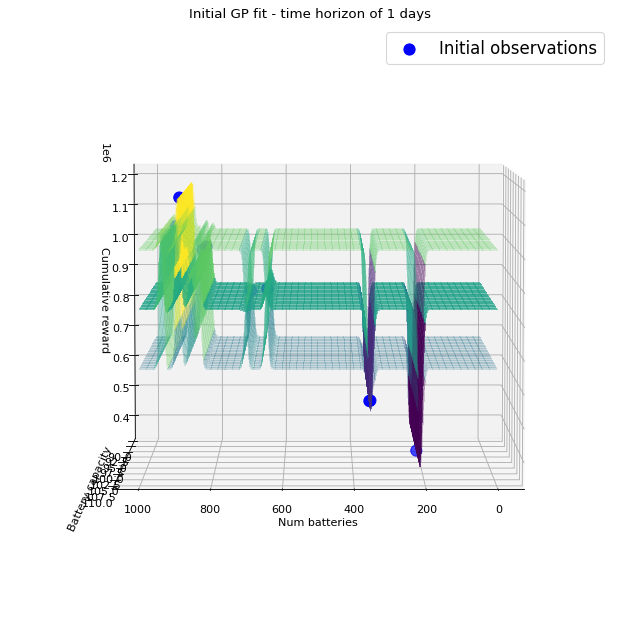

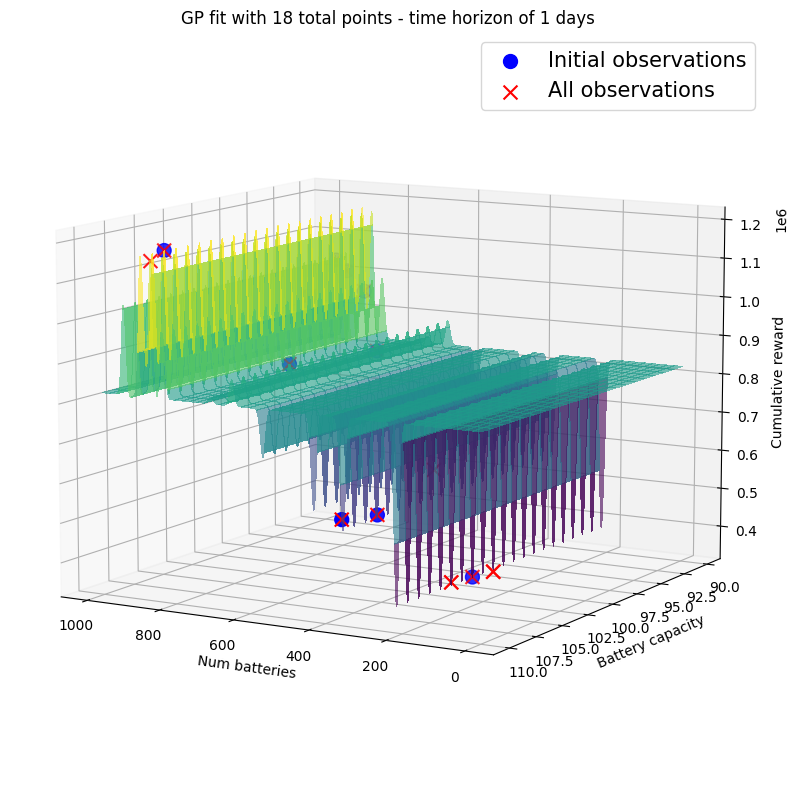

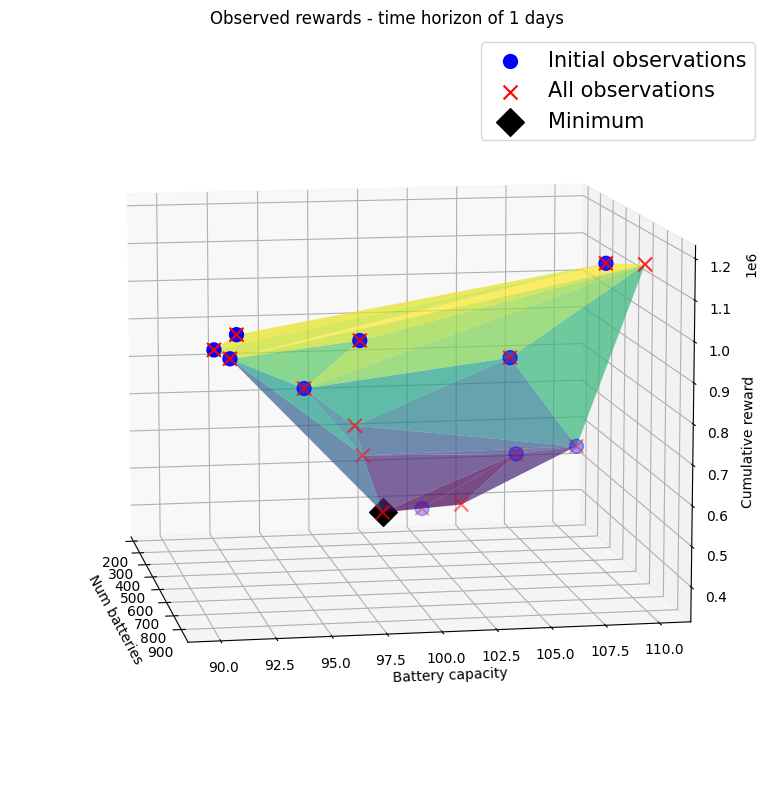

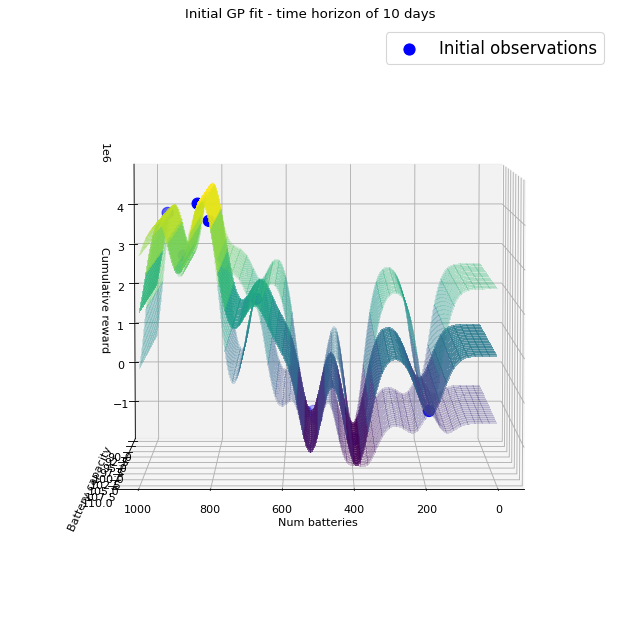

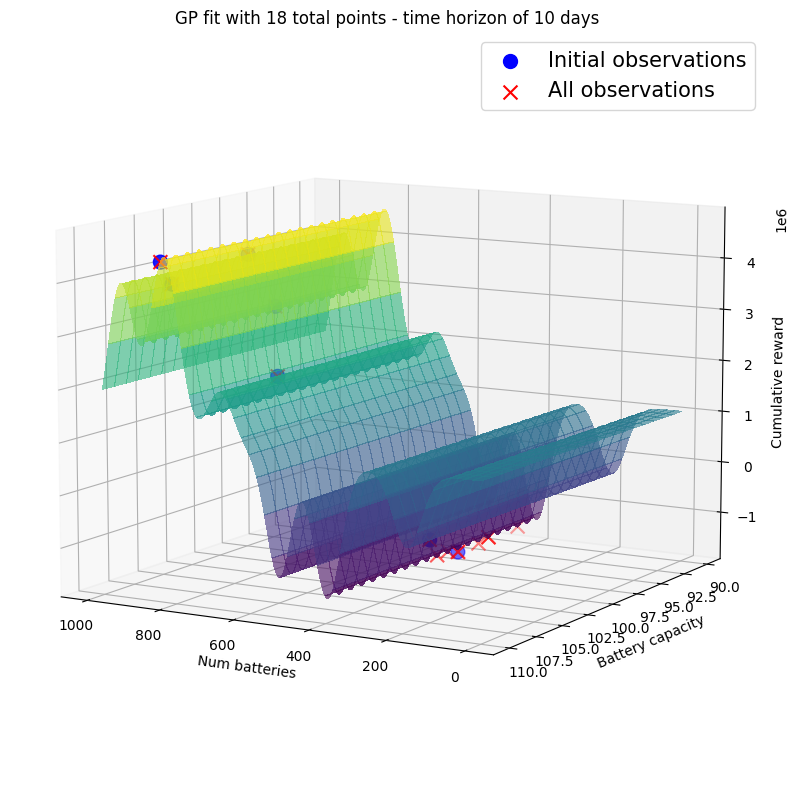

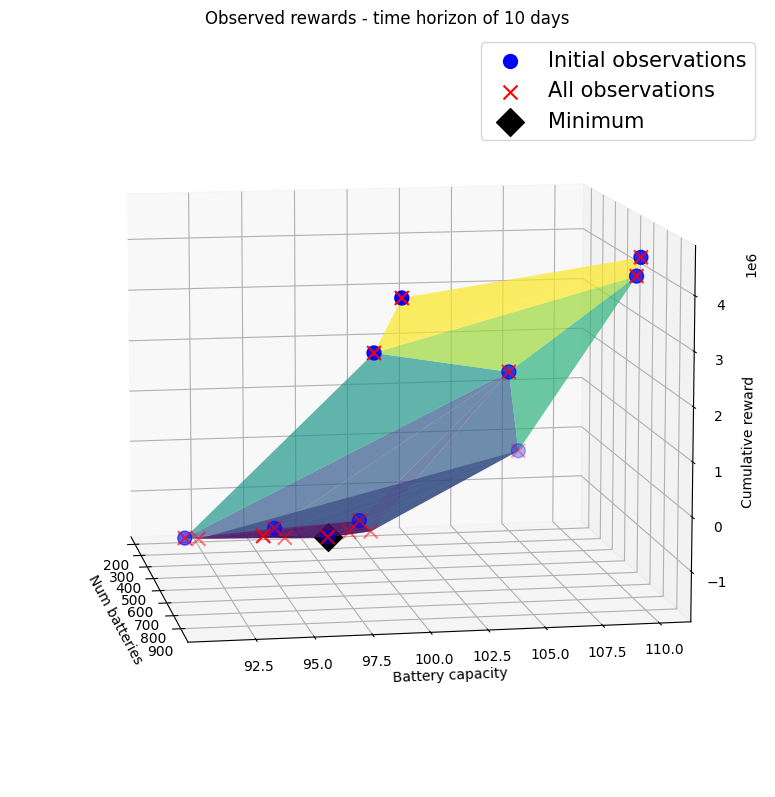

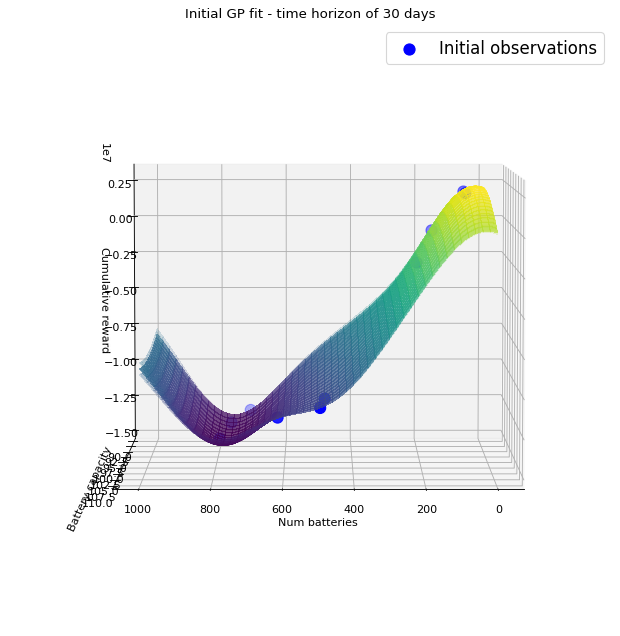

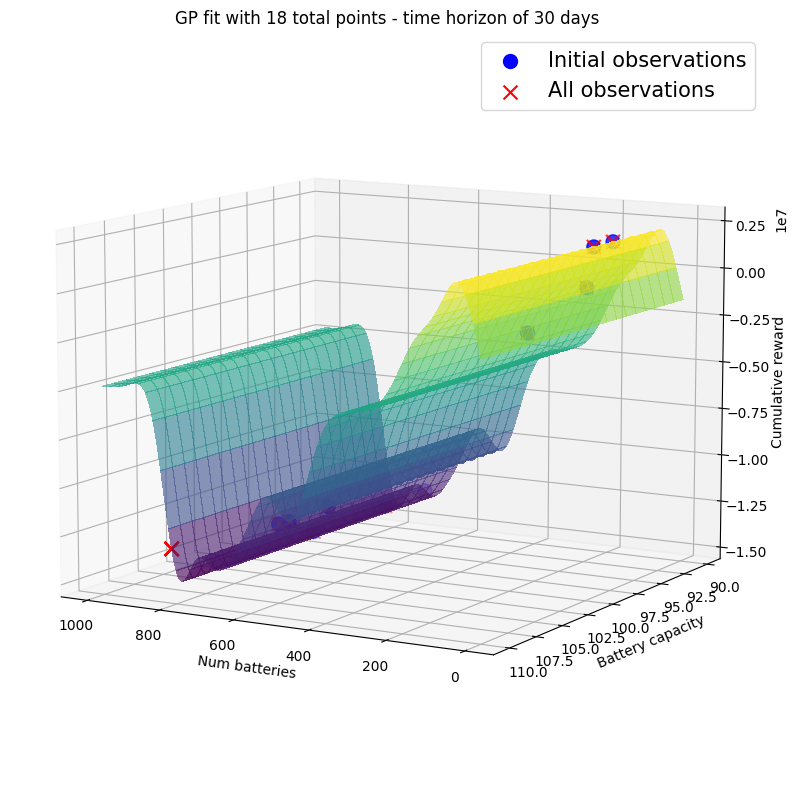

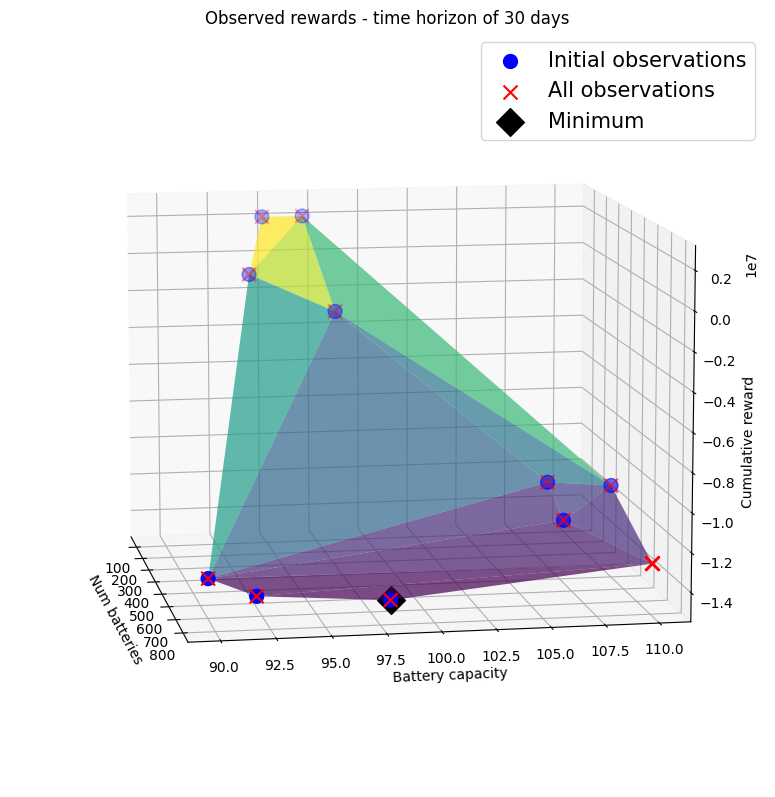

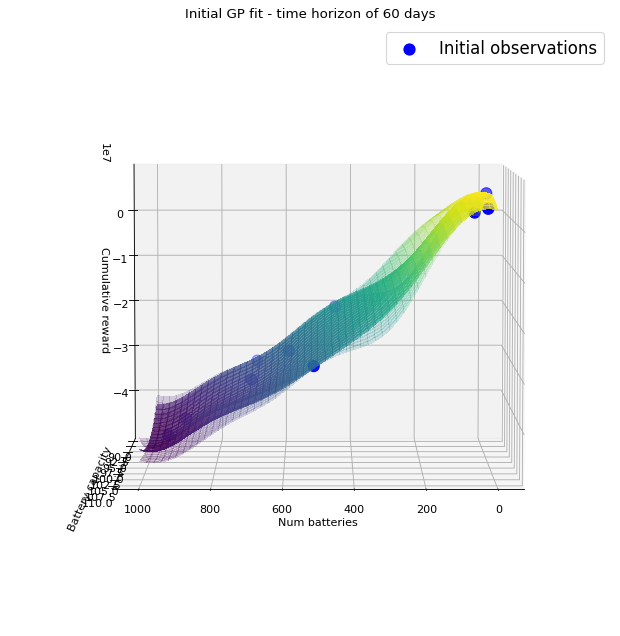

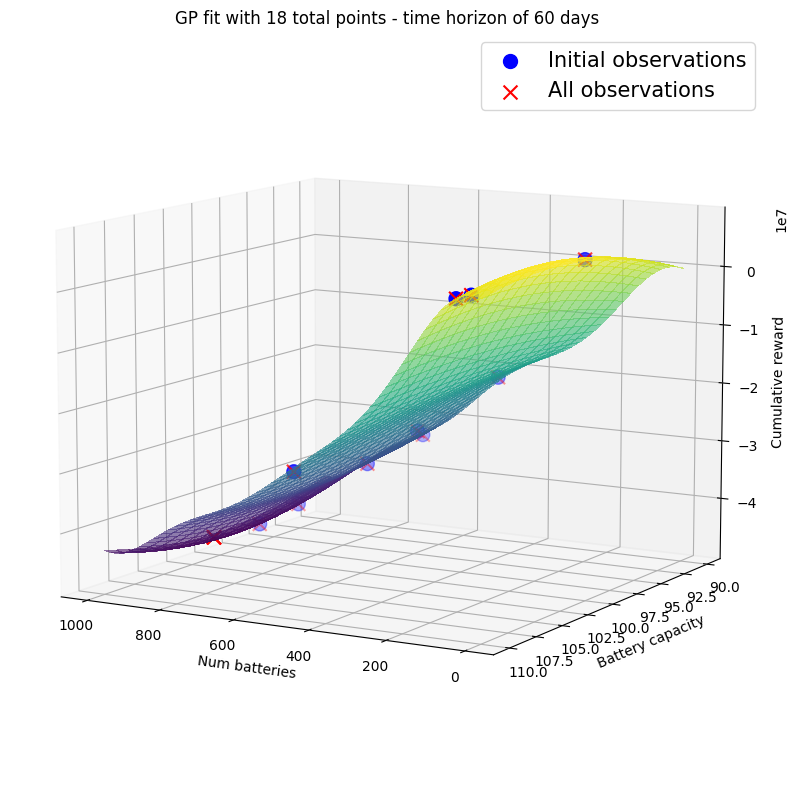

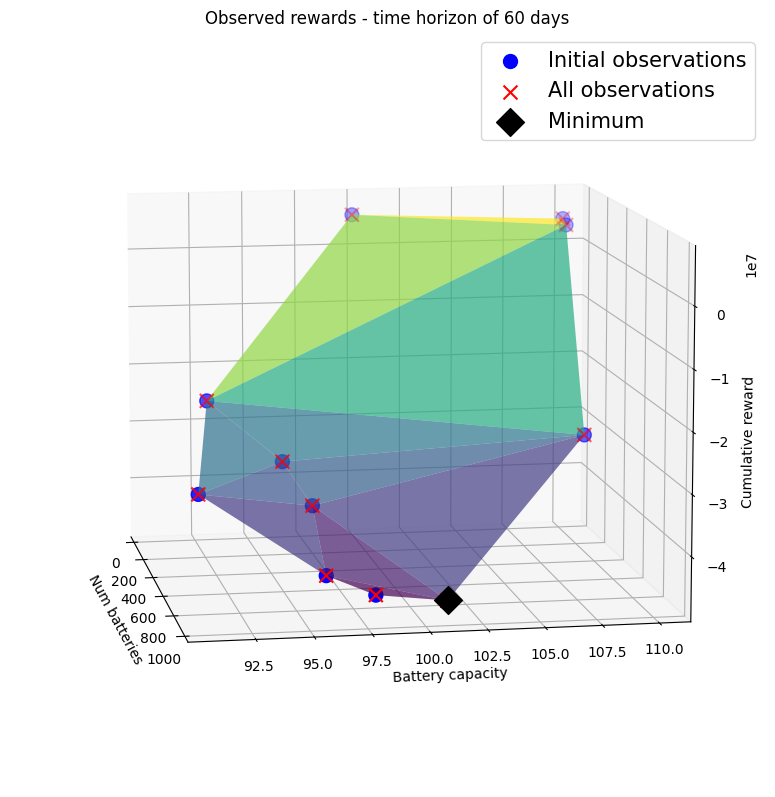

In [37]:
num_batteries = DiscreteParameter('num_batteries', range(0, max_num_batteries+1))
max_battery_capacities = DiscreteParameter('max_battery_capacity', range(min_battery_capacity, max_battery_capacity+1))

all_results = {}
for num_days in [1, 10, 30, 60]:
    config_res = {}

    timesteps_per_day = timesteps_per_week/7
    time_horizon_value = timesteps_per_day*num_days
    
    print('')
    print(20*'=' + " Simulating with time horizon of {} days ".format(num_days) + 20*'=')

    # Specify time horizon here changing time_horizon_value above
    time_horizon = DiscreteParameter('time_horizon', [time_horizon_value])

    parameters = [num_batteries, max_battery_capacities, time_horizon]
    parameter_space = ParameterSpace(parameters)

    design = RandomDesign(parameter_space)

    # Get initial data points
    X = design.get_samples(num_data_points)
    start = time.time()
    Y = f_multiprocess(X)
    end = time.time()
    print("Getting {} initial simulation points took {} seconds".format(num_data_points, round(end - start, 0)))
    
    # Kernel Specification
    kr = GPy.kern.RBF(input_dim=X.shape[1]-1, ARD=True)  # exclude time dim
    kb = GPy.kern.Bias(input_dim=X.shape[1]-1)
    kernel = kr+kb

    # Some prior distributions for model parameters
    v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
    l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

    # Some prior distributions for model parameters
    gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
    gpy_model.kern.rbf.variance.set_prior(v_prior)
    gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
    gpy_model.Gaussian_noise.variance.constrain_fixed()

    # gpy_model.optimize()
    gpy_model.optimize_restarts(
        num_restarts=10, robust=False, verbose=False, messages=False)

    # Logging GP fit
    # _ = gpy_model.plot()
    # print(gpy_model.kern.rbf.variance)
    display(gpy_model)
    print(gpy_model.kern.rbf.lengthscale)

    model_emukit = GPyModelWrapper(gpy_model)

    # Plot 3D decision boundary
    mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                            min_battery_capacity:max_battery_capacity+1:1]
    positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
    positions_with_time = np.append(positions, np.reshape(
        np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

    mu_plot, var_plot = model_emukit.predict(positions_with_time)
    os.mkdir('img/time_horizon/{}/'.format(num_days))
    kwargs = {
        'X': X,
        'Y': Y,
        'mesh_X': mesh_X,
        'mesh_Y': mesh_Y,
        'mu_plot': mu_plot,
        'var_plot': var_plot,
        'title': "Initial GP fit - time horizon of {} days".format(num_days),
        'elev': 5,
        'angle': 90,
        'dpi': 80,
        'save_fig_path': "img/time_horizon/{}/{}_init".format(num_days, num_days)
    }
    fig, ax = plot_3d_boundary(**kwargs)

    # Choose acquisition function
    ei_acq = ExpectedImprovement(model_emukit)
    acq_func = ei_acq

    # Load core elements for Bayesian optimization
    optimizer = GradientAcquisitionOptimizer(space=parameter_space)

    # Create the Bayesian optimization object
    batch_size = 8
    bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                            space=parameter_space,
                                            acquisition=acq_func,
                                            batch_size=batch_size)

    # Run the loop and extract the optimum;  we either complete 10 steps or converge
    max_iters = 1
    epsilon = 0.01
    stopping_condition = (FixedIterationsStoppingCondition(
        i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

    start = time.time()
    bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
    end = time.time()
    print("Successfully ran loop")
    successful_sample = True

    # Get acquired data
    new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
    new_order = np.argsort(new_X[:, 0])
    new_X = new_X[new_order, :]
    new_Y = new_Y[new_order]
    total_num_points = new_Y.shape[0]
    num_eval_points = total_num_points-num_data_points
    print("Getting {} simulation points (batch size {}) took {} seconds".format(num_eval_points, batch_size, round(end - start, 0)))

    results = bayesopt_loop.get_results()
    print("minimum X: ", end='')
    print(results.minimum_location)
    print("minimum Y: ", end='')
    print(round(results.minimum_value, 0))

    print("Number of (new) points evaluated: {} (batch size {})".format(
        num_eval_points, batch_size))

    # Save model
    config_res['model'] = gpy_model.to_dict()
    config_res['best_reward'] = (results.minimum_location, results.minimum_value)
    config_res['num_data_points'] = num_data_points # number of initial data points
    config_res['num_eval_points'] = num_eval_points # num of BO points evaluated
    config_res['batch_size'] = batch_size
    config_res['max_iters'] = max_iters
    config_res['epsilon'] = epsilon
    config_res['eval_iters'] = num_eval_points//batch_size
    config_res['eval_time'] = round(end-start, 0)

    # Plot 3D decision boundary
    mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                            min_battery_capacity:max_battery_capacity+1:1]
    positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
    positions_with_time = np.append(positions, np.reshape(
        np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

    mu_plot, var_plot = model_emukit.predict(positions_with_time)
    kwargs = {
        'X': X,
        'Y': Y,
        'plot_new': True,
        'new_X': new_X,
        'new_Y': new_Y,
        'mesh_X': mesh_X,
        'mesh_Y': mesh_Y,
        'mu_plot': mu_plot,
        'var_plot': var_plot,
        'title': "GP fit with {} total points - time horizon of {} days".format(total_num_points, num_days),
        'plot_ci': False,
        'elev': 10,
        'angle': 120,
        'save_fig_path': "img/time_horizon/{}/{}_sim".format(num_days, num_days),
    }
    fig, ax = plot_3d_boundary(**kwargs)

    kwargs = {
        'X': X,
        'Y': Y,
        'new_X': new_X,
        'new_Y': new_Y,
        'elev': 10,
        'angle': 120,
        'title': "Observed rewards - time horizon of {} days".format(num_days),
        'save_fig_path': "img/time_horizon/{}/{}_obs".format(num_days, num_days)
    }
    fig, ax = plot_3d_observed_rewards(**kwargs)

    # Save results
    config_res['mu_plot'] = mu_plot
    config_res['var_plot'] = var_plot
    all_results[num_days] = config_res

In [43]:
print(parameter_space.parameter_names)
for days in all_results.keys():
    min_X, min_Y = all_results[days]['best_reward']
    print(min_X, end='\t')
    print(min_X[2]/48, end='\t')
    print(round(min_Y))

['num_batteries', 'max_battery_capacity', 'time_horizon']
[215. 101.  48.]	1.0	372360
[393.  98. 480.]	10.0	-1486863
[ 794.   98. 1440.]	30.0	-14271163
[ 985.  101. 2880.]	60.0	-46666835


Get rewards of initial set of points

In [53]:
Y = f_multiprocess(X)

100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


Specify kernels, priors, fit GP to initial set, log the GP, plot initial fit

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


GP_regression.,value,constraints,priors
sum.rbf.variance,712882.1850997368,+ve,"Ga(1e+04, 10)"
sum.rbf.lengthscale,"(2,)",+ve,"Ga(10, 0.1)"
sum.bias.variance,444436621.65634894,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


  index  |  GP_regression.sum.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                        35.45359253  |      +ve      |  Ga(10, 0.1)
  [1]    |                      1828.71489343  |      +ve      |  Ga(10, 0.1)


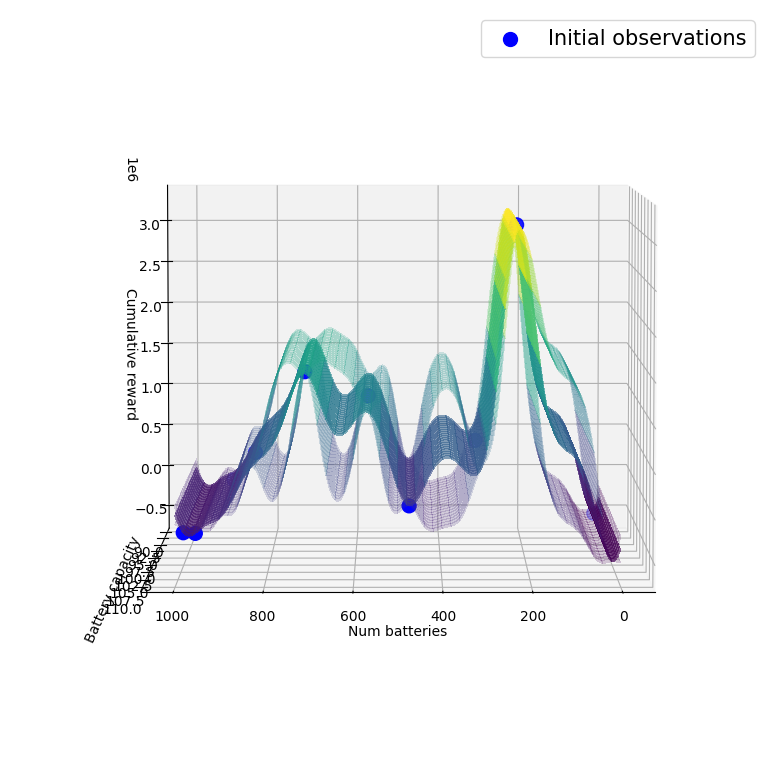

In [97]:
# Kernel Specification
kr = GPy.kern.RBF(input_dim=X.shape[1]-1, ARD=True) # exclude time dim
kb = GPy.kern.Bias(input_dim=X.shape[1]-1)
kernel = kr+kb

# Some prior distributions for model parameters
v_prior = GPy.priors.Gamma.from_EV(1000, 100.)
l_prior = GPy.priors.Gamma.from_EV(100, 1000.)

# Some prior distributions for model parameters
gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)
gpy_model.kern.rbf.variance.set_prior(v_prior)
gpy_model.kern.rbf.lengthscale.set_prior(l_prior)
gpy_model.Gaussian_noise.variance.constrain_fixed()

# gpy_model.optimize()
gpy_model.optimize_restarts(num_restarts=10, robust=False, verbose=False, messages=False)

# Logging GP fit
# _ = gpy_model.plot()
# print(gpy_model.kern.rbf.variance)
display(gpy_model)
print(gpy_model.kern.rbf.lengthscale)

model_emukit = GPyModelWrapper(gpy_model)

# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)

mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'elev': 5,
    'angle': 90
}
fig, ax = plot_3d_boundary(**kwargs)

Specify acq function, run BO, print best reward found

In [98]:
# Choose acquisition function
ei_acq = ExpectedImprovement(model_emukit)
acq_func = ei_acq

# Load core elements for Bayesian optimization
optimizer = GradientAcquisitionOptimizer(space=parameter_space)

# Create the Bayesian optimization object
batch_size = 3
bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                         space=parameter_space,
                                         acquisition=acq_func,
                                         batch_size=batch_size)

# Run the loop and extract the optimum;  we either complete 10 steps or converge
max_iters = 3
epsilon = 0.01
stopping_condition = (FixedIterationsStoppingCondition(
    i_max=max_iters) | ConvergenceStoppingCondition(eps=epsilon))

bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
print("Successfully ran loop")
successful_sample = True

# Get acquired data
new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]
total_num_points = new_Y.shape[0]

results = bayesopt_loop.get_results()
print("minimum X: ")
print(results.minimum_location)
print("minimum Y: ")
print(results.minimum_value)

print("Number of (new) points evaluated: {} (batch size {})".format(
    total_num_points-num_data_points, batch_size))

print(results.best_found_value_per_iteration)

INFO:emukit.bayesian_optimization.loops.bayesian_optimization_loop:Batch size is 3, using LocalPenalizationPointCalculator
INFO:emukit.core.loop.outer_loop:Starting outer loop
INFO:emukit.core.loop.outer_loop:Iteration 0
INFO:emukit.core.loop.model_updaters:Updating parameters of the model
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.optimization.gradient_acquisition_optimizer:Starting gradient-based optimization of acquisition function <class 'emukit.core.acquisition.acquisition.Sum'>
INFO:emukit.core.loop.user_function:Evaluating user function for 3 point(s)
100%|██████████| 3/3 [00:18<00:00,  6.26s/it]
INFO:emukit.core.loop.outer_loop:Iteration 1
INFO:emukit.core.loop.mode

Successfully ran loop
minimum X: 
[295.  99. 336.]
minimum Y: 
-575640.1985841452
Number of (new) points evaluated: 9 (batch size 3)
[-500337.35321147 -500337.35321147 -500337.35321147 -500337.35321147
 -500337.35321147 -500337.35321147 -500337.35321147 -500337.35321147
 -500337.35321147 -500337.35321147 -553368.68333334 -553368.68333334
 -553368.68333334 -553368.68333334 -553368.68333334 -553368.68333334
 -575640.19858415 -575640.19858415 -575640.19858415]


Plot the resulting 3D decision boundary

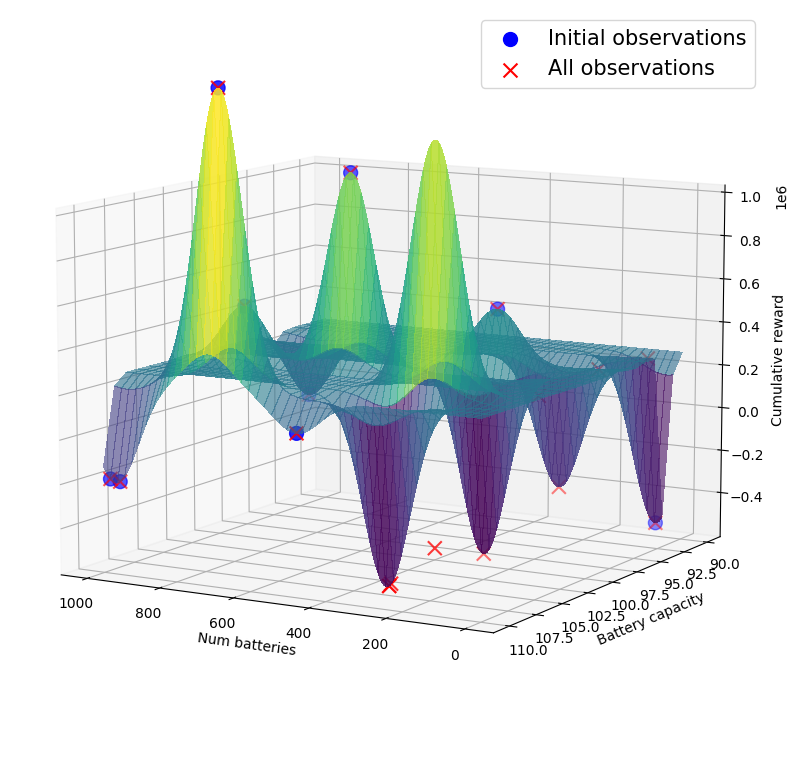

In [107]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
positions_with_time = np.append(positions, np.reshape(
    np.array([time_horizon_value for _ in range(positions.shape[0])]), (-1, 1)), axis=1)


mu_plot, var_plot = model_emukit.predict(positions_with_time)
kwargs = {
    'X': X,
    'Y': Y,
    'plot_new': True,
    'new_X': new_X,
    'new_Y': new_Y,
    'mesh_X': mesh_X,
    'mesh_Y': mesh_Y,
    'mu_plot': mu_plot,
    'var_plot': var_plot,
    'plot_ci': False,
    'elev': 10,
    'angle': 120,
    'z_lims': (min(new_Y), 1e6)
}
fig, ax = plot_3d_boundary(**kwargs)


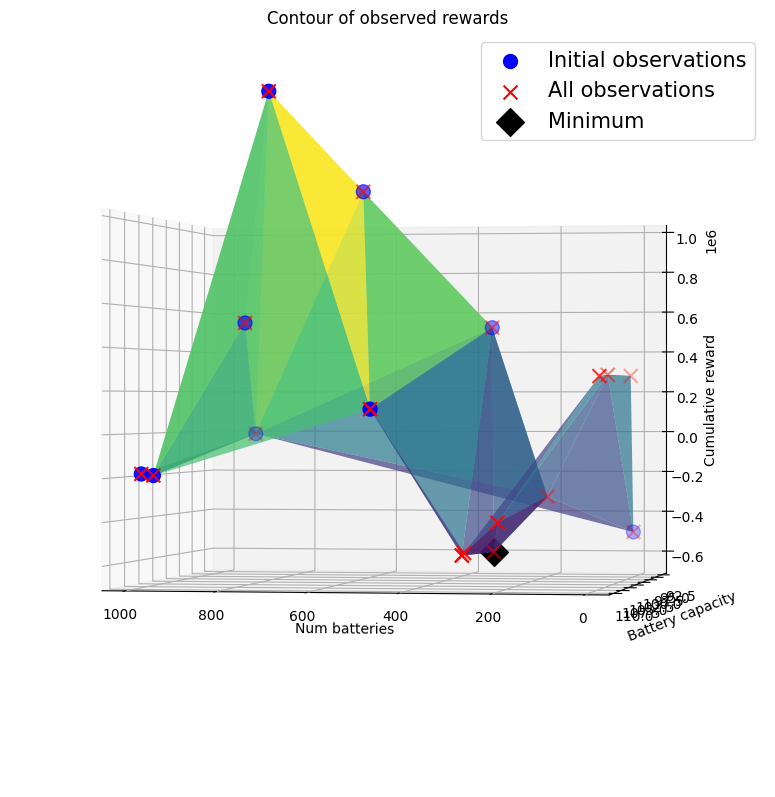

In [120]:
kwargs = {
    'X': X,
    'Y': Y,
    'new_X': new_X,
    'new_Y': new_Y,
    'elev': 0,
    'angle': 100,
    'z_lims': (min(new_Y)-1e5, 1e6)
}
fig, ax = plot_3d_observed_rewards(**kwargs)
plt.show()

In [ ]:
results = bayesopt_loop.get_results()
results.minimum_location, results.minimum_value # , results.best_found_value_per_iteration

(array([795.,  98.]), -49066704.85591315)

Plot 3D decision boundary

In [ ]:
# Plot 3D decision boundary
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1,
                          min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T

mu_plot, var_plot = model_emukit.predict(positions)

fig = plt.figure(figsize=(15, 15))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape(
    (1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.60)

# surf_var = ax.plot_surface(mesh_X, mesh_Y, (mu_plot-var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.10)
# surf_var = ax.plot_surface(me sh_X, mesh_Y, (mu_plot+var_plot).reshape((1000, 21)), cmap='viridis', linewidth=0, antialiased=False, alpha=0.20)

# fig.colorbar(surf)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

ax.grid(True)
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")
plt.title("GP mean with {}".format(gpy_model.kern.name))
plt.legend(loc='upper right', prop={'size': 15})

# for angle in range(0, 360, 40):
ax.view_init(elev=10., azim=80)

plt.show()


Plot actual observation surface

Minimum value found:
[328.  90.] -620552.6527396751


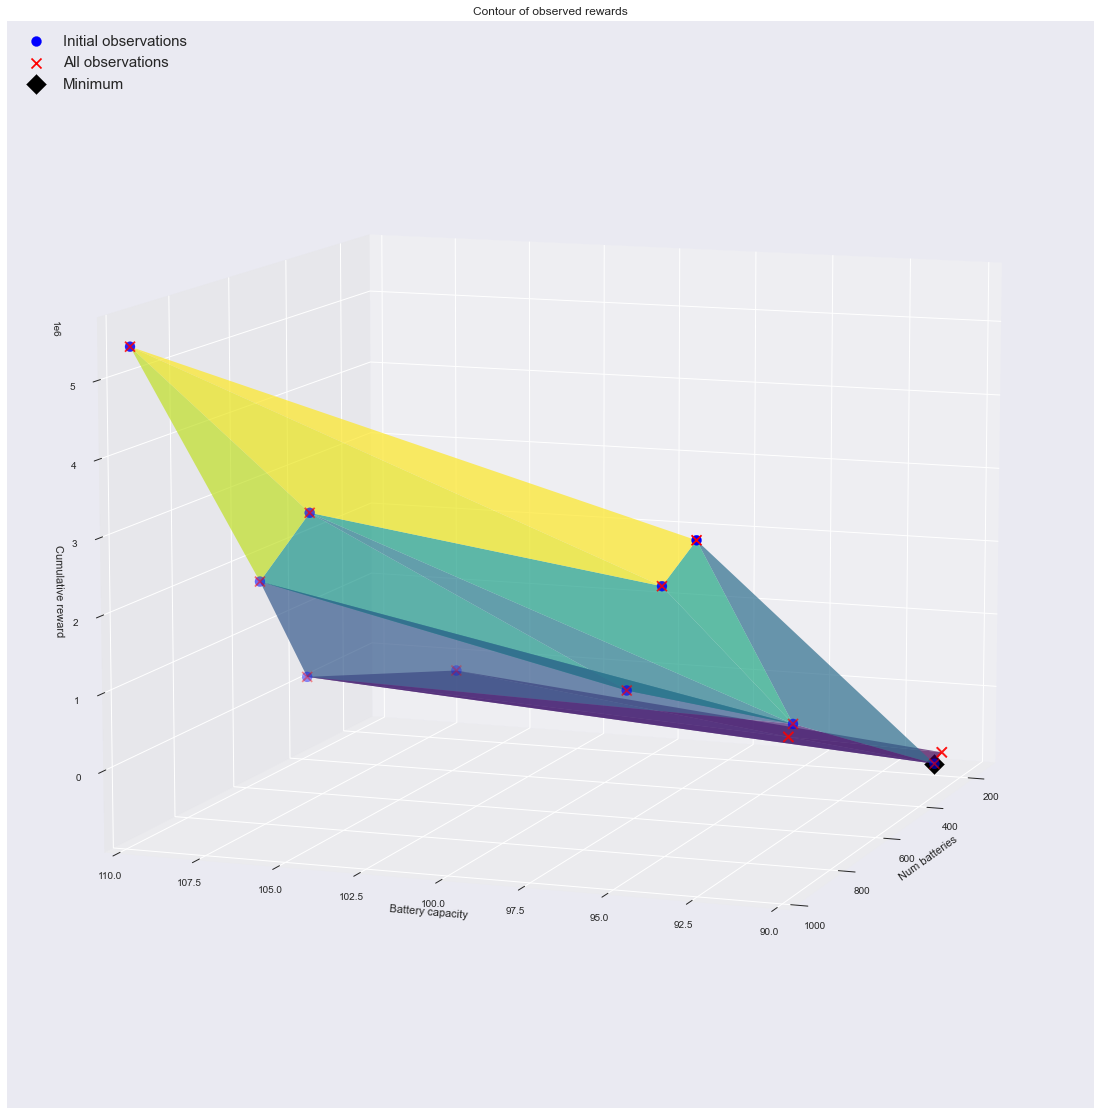

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')

new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]

x_plot = np.reshape(
    np.array([i for i in range(0, max_num_batteries)]), (-1, 1))
X_plot = np.append(x_plot, np.reshape(
    [100 for i in range(max_num_batteries)], (-1, 1)), axis=1)
mu_plot, var_plot = model_emukit.predict(X_plot)

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('viridis'), alpha=0.70)
# fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)
ax.scatter(min_X[0], min_X[1], min_Y, c='black',
           marker='D', label="Minimum", s=200)

LEGEND_SIZE = 15
ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel("Num batteries")
ax.set_ylabel("Battery capacity")
ax.set_zlabel("Cumulative reward")

ax.view_init(elev=10., azim=20)
ax.set_ylim(110, 90)
ax.grid(True)
plt.title("Contour of observed rewards")
print("Minimum value found:")
print(min_X, min_Y)
# plt.savefig("img/rq_sim.png")

plt.show()


## Try/except

In [ ]:
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

successful_sample = False
num_tries = 0
max_num_tries = 3

use_default = False

while not successful_sample and num_tries < max_num_tries:

    print(f"CURRENT ATTEMPT #{num_tries}")

    X = design.get_samples(8)
    Y = f_multiprocess(X)

    # Plot init values
    # plot_reward(X, Y, parameter_space.parameter_names)

    # Kernel Specification
    kr = GPy.kern.RBF(input_dim=X.shape[1], lengthscale=2, variance=9, ARD=True)
    kb = GPy.kern.Bias(input_dim=X.shape[1], variance=1e-5)
    kernel = kr+kb  

    try:
        # Emulator model
        if use_default: gpy_model = GPRegression(X, Y)
        else:
            # Some prior distributions for model parameters
            gpy_model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(1., 10.))
            gpy_model.kern.rbf.variance.set_prior(GPy.priors.Gamma.from_EV(10., 100.))
            gpy_model.kern.rbf.lengthscale.set_prior(GPy.priors.Gamma.from_EV(60, 1000.))  # gamma prior, < l > = 120, var(l) = 2000
            gpy_model.Gaussian_noise.variance.constrain_fixed()

            gpy_model = GPy.models.GPRegression(X, Y, kernel, noise_var=1e-10)

    
        gpy_model.optimize()
        print("Okay to optimize")

        model_emukit = GPyModelWrapper(gpy_model)
        
        # Choose acquisition function
        ei_acq = ExpectedImprovement(model_emukit)
        nlcb_acq = NegativeLowerConfidenceBound(model_emukit)
        pi_acq = ProbabilityOfImprovement(model_emukit)
        acq_func = ei_acq


        # Load core elements for Bayesian optimization
        optimizer = GradientAcquisitionOptimizer(space=parameter_space)

        # Create the Bayesian optimization object
        batch_size = 3
        bayesopt_loop = BayesianOptimizationLoop(model=model_emukit,
                                                    space=parameter_space,
                                                    acquisition=acq_func,
                                                    batch_size=batch_size)

        # Run the loop and extract the optimum;  we either complete 10 steps or converge
        max_iters = 10
        stopping_condition = (
            FixedIterationsStoppingCondition(
                i_max=max_iters) | ConvergenceStoppingCondition(eps=0.01)
        )

        bayesopt_loop.run_loop(f_multiprocess, stopping_condition)
        print("Successfully ran loop")
        successful_sample = True

        # Get acquired data
        new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
        new_order = np.argsort(new_X[:, 0])
        new_X = new_X[new_order, :]
        new_Y = new_Y[new_order]
        
    except:
        num_tries += 1


In [ ]:
min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)

min_X, min_Y

(array([557.,  92.]), -4115764.825228045)

Minimum value found:
[332. 102.] 669709.6282651341


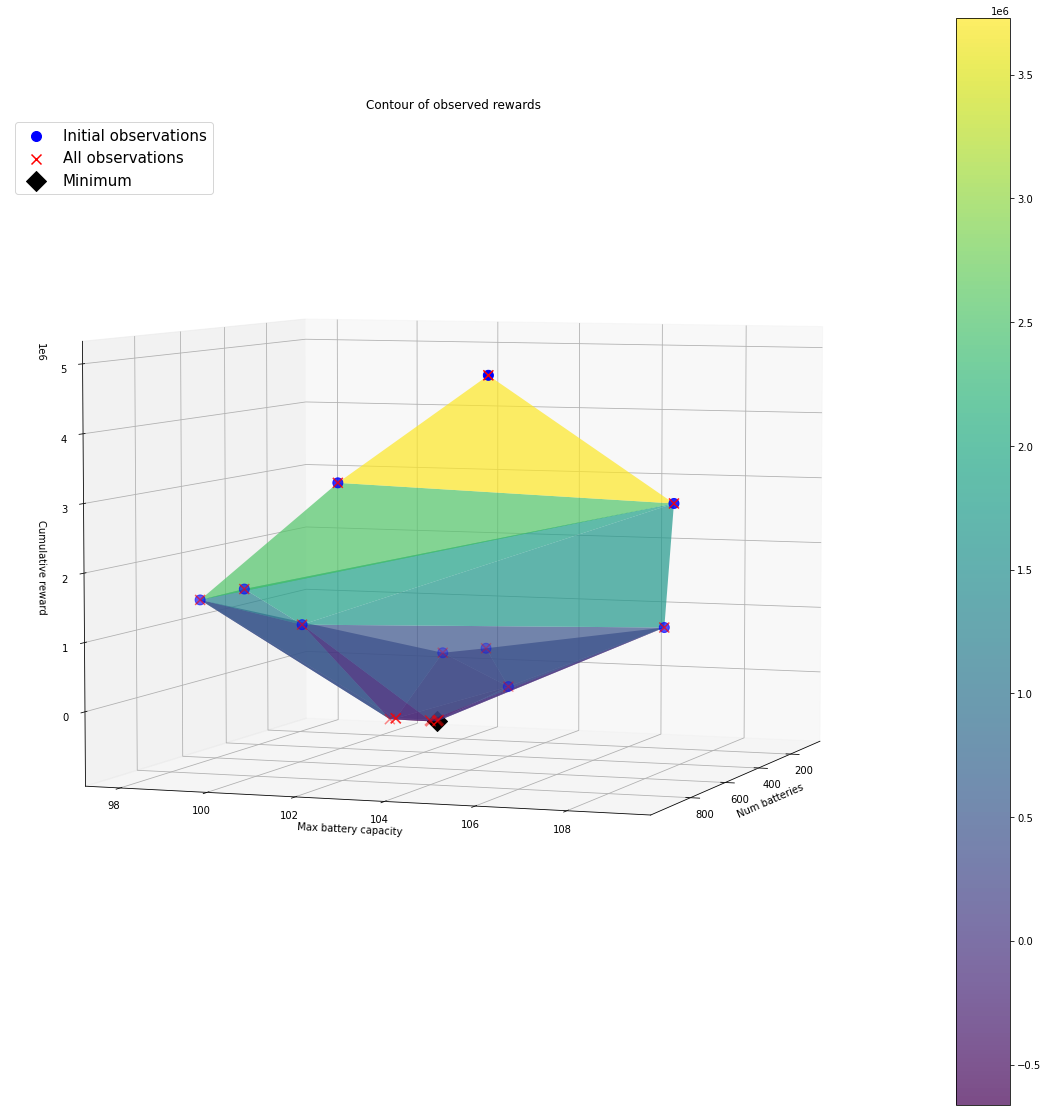

In [ ]:
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')

new_X, new_Y = bayesopt_loop.loop_state.X, bayesopt_loop.loop_state.Y
new_order = np.argsort(new_X[:, 0])
new_X = new_X[new_order, :]
new_Y = new_Y[new_order]

x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1, 1))
X_plot = np.append(x_plot, np.reshape(
    [100 for i in range(max_num_batteries)], (-1, 1)), axis=1)
mu_plot, var_plot = model_emukit.predict(X_plot)

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(), new_Y.flatten(), cmap=cm.get_cmap('viridis'), alpha=0.70)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations", s=100)

min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)
ax.scatter(min_X[0], min_X[1], min_Y, c='black',
           marker='D', label="Minimum", s=200)

LEGEND_SIZE = 15
ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel("Num batteries")
ax.set_ylabel("Max battery capacity")
ax.set_zlabel("Cumulative reward")

ax.view_init(elev=5., azim=20)
ax.grid(True)
plt.title("Contour of observed rewards")
print("Minimum value found:")
print(min_X, min_Y)
plt.show()


## Visualize and Get Extrema

In [ ]:
min_X = new_X[np.argmin(new_Y)]
min_Y = np.min(new_Y)

min_X, min_Y


(array([394.,  92.]), -4437379.057100313)

### Simple Plot

(<Figure size 864x864 with 2 Axes>,
 <Axes3DSubplot:xlabel='num_batteries', ylabel='max_battery_capacity'>)

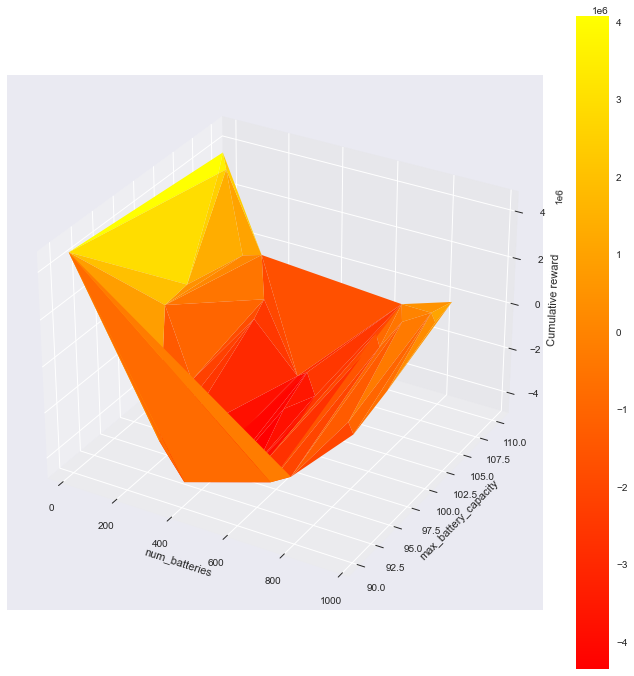

In [ ]:
plot_reward(new_X, new_Y, parameter_space.parameter_names)

### 2D Plot

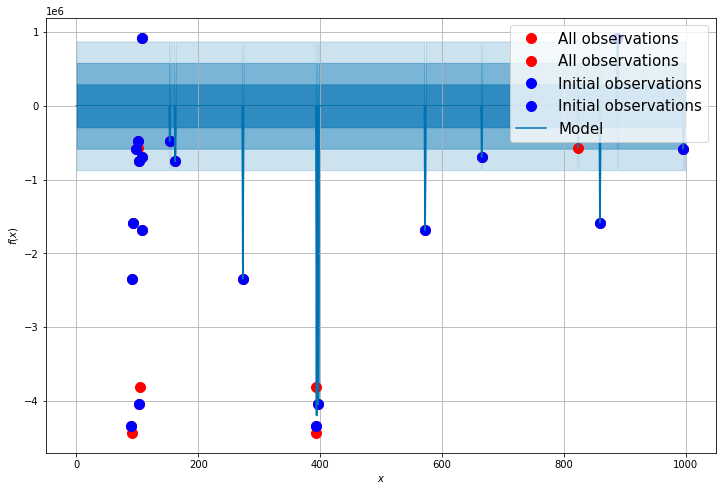

In [ ]:
x_plot = np.reshape(np.array([i for i in range(0, max_num_batteries)]), (-1,1))
mu_plot, var_plot = model_emukit.predict(x_plot)

plt.figure(figsize=(12, 8))
LEGEND_SIZE = 15
plt.plot(new_X, new_Y, "ro", markersize=10, label="All observations")
plt.plot(X, Y, "bo", markersize=10, label="Initial observations")
# plt.plot(x_plot, y_plot, "k", label="Objective Function")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)

plt.legend(loc='upper right', prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
# plt.xlim(0, 25)
plt.show()

## 3D Plots

#### Inferred Surface

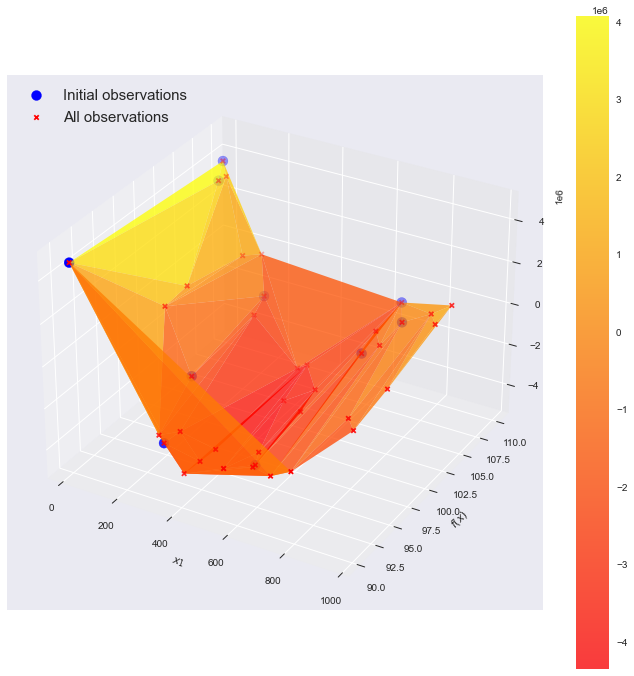

In [ ]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)


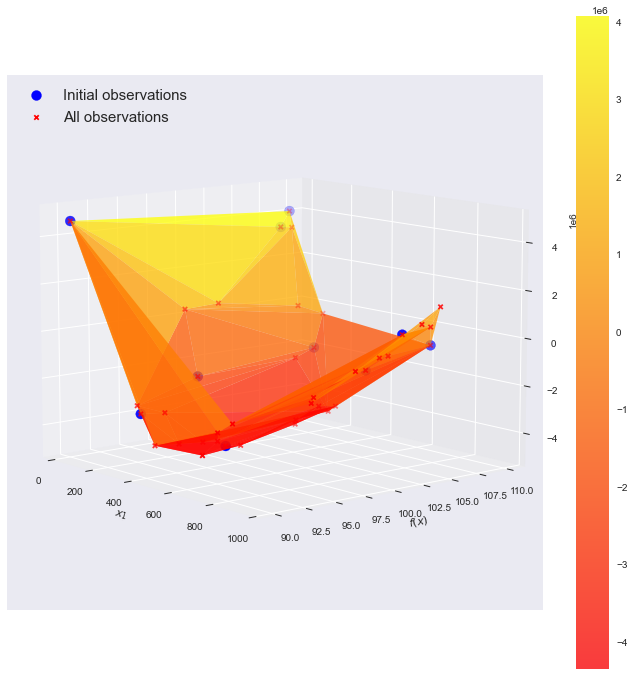

In [ ]:
import time
plt.style.use('seaborn-colorblind')
fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')

im = ax.plot_trisurf(new_X[:, 0].flatten(), new_X[:, 1].flatten(
), new_Y.flatten(), cmap=cm.get_cmap('autumn'), alpha=0.75)
fig.colorbar(im)

ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), Y.flatten(),
           s=100, marker="o", color="b", label="Initial observations")
ax.scatter(new_X[:, 0].flatten(), new_X[:, 1].flatten(),
           new_Y.flatten(), marker="x", color="r", label="All observations")

ax.legend(loc=2, prop={'size': LEGEND_SIZE})
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")
ax.set_ylabel(r"$f(x)$")
ax.grid(True)

for angle in range(0, 360, 40):
    ax.view_init(elev=10., azim=angle)
    plt.savefig("img/plot_{}.png".format(angle))



#### Prediction Surface

In [ ]:
mesh_X, mesh_Y = np.mgrid[1:max_num_batteries+1:1, min_battery_capacity:max_battery_capacity+1:1]
positions = np.vstack([mesh_X.ravel(), mesh_Y.ravel()]).T
mu_plot, var_plot = model_emukit.predict(positions)

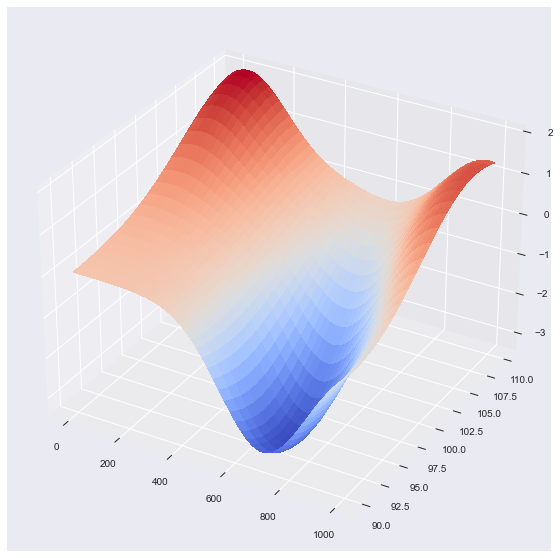

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_X, mesh_Y, mu_plot.reshape((1000,21)), cmap=cm.coolwarm,linewidth=0, antialiased=False)